# Computing Price Effects with Data

We will use data from a Fast food restaurant in China... These data are collected in three files: 1) transaction data per day, 2) type of products, 3) information per day on climate, etc. 
 

In [0]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

We have to load data from google drive. To do this, we need to mount a disk so that this notebook can find our data. You will be asked for an authentificatio key which you will get after clicking on the link. 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Put your path to the folder here. 

In [0]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/micro')

Here is the transaction file

In [5]:
ts = pd.read_csv('sales/transactions.csv')
ts.head()

STORE CALENDAR_DATE  PRICE  QUANTITY  SELL_ID  SELL_CATEGORY
0      1        1/1/12  15.50        46     1070              0
1      1        1/1/12  12.73        22     2051              2
2      1        1/1/12  12.75        18     2052              2
3      1        1/1/12  12.60        30     2053              2
4      1        1/2/12  15.50        70     1070              0

This on contains meta-data on products

In [6]:
pr = pd.read_csv('sales/meta.csv')
pr.head()

SELL_ID  SELL_CATEGORY  ITEM_ID ITEM_NAME
0     1070              0     7821    BURGER
1     3055              0     3052    COFFEE
2     3067              0     5030      COKE
3     3028              0     6249  LEMONADE
4     2051              2     7821    BURGER

And finally this one contains information on the day. 

In [7]:
da = pd.read_csv('sales/dates.csv')
da.head()

CALENDAR_DATE  YEAR  ... AVERAGE_TEMPERATURE  IS_OUTDOOR
0        1/1/12  2012  ...                24.8           0
1        1/2/12  2012  ...                24.8           0
2        1/3/12  2012  ...                32.0           1
3        1/4/12  2012  ...                32.0           1
4        1/5/12  2012  ...                24.8           0

[5 rows x 7 columns]

We create a variable that takes value 1 if it is a holiday and zero if not. 

In [0]:
da['HOL'] = np.where(da['HOLIDAY'].isna()==False,1.0,0.0)

We will concentrate on burgers sold. 

In [0]:
ts = ts[ts['SELL_ID']==1070]

In [10]:
ts.head()

STORE CALENDAR_DATE  PRICE  QUANTITY  SELL_ID  SELL_CATEGORY
0       1        1/1/12   15.5        46     1070              0
4       1        1/2/12   15.5        70     1070              0
8       1        1/3/12   15.5        62     1070              0
12      1        1/4/12   15.5        88     1070              0
16      1        1/5/12   15.5       104     1070              0

We do a merge with the date file...

In [0]:
df = ts.merge(da,on='CALENDAR_DATE')

In [12]:
df.head()

STORE CALENDAR_DATE  PRICE  ...  AVERAGE_TEMPERATURE  IS_OUTDOOR  HOL
0      1        1/1/12   15.5  ...                 24.8           0  1.0
1      1        1/2/12   15.5  ...                 24.8           0  1.0
2      1        1/3/12   15.5  ...                 32.0           1  1.0
3      1        1/4/12   15.5  ...                 32.0           1  0.0
4      1        1/5/12   15.5  ...                 24.8           0  0.0

[5 rows x 13 columns]

We can check whether prices vary in time (we do not know why). 

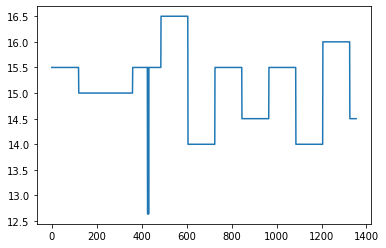

In [14]:
plt.figure()
plt.plot(df.index,df['PRICE'])
plt.show()

Quantity sold per day also varies

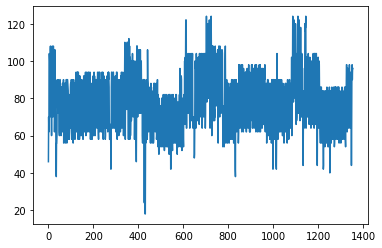

In [0]:
plt.figure()
plt.plot(df.index,df['QUANTITY'])
plt.show()

# Preferences and Demand

Assume the preferences ($Q$ is quantity of burgers and $M$ is money): 
$$ u(Q,M) = V(Q) + M $$

Assume $V(Q) = \frac{e^{\alpha_0 + \alpha_1 Z + \epsilon} }{\alpha_Q}Q^{\alpha_Q} $ where $Z$ is information on the day, $\epsilon$ is a random preference term. With these preferences, the inverse demand is given by $P(Q) = e^{\alpha_0 + \alpha_1 Z + \epsilon} Q^{\alpha_Q-1}$.

We can take log to obtain:

$$ \log P(Q) = \alpha_0 + \alpha_1 Z + (\alpha_Q-1)\log Q + \epsilon $$

Solving for $Q$ we get demand:

$$ \log Q(P) = \pi_0 + \pi_1 Z + \pi_P \log P + \nu $$

where $\pi_0 = \frac{\alpha_0}{\alpha_Q-1}$, $\pi_1 = \frac{\alpha_1}{\alpha_Q-1}$, $\pi_P = \frac{1}{\alpha_Q-1}$ and $\nu = \frac{1}{\alpha_Q-1}\epsilon$. 

The price elasticity is: 
$$ \frac{d\log Q}{d\log P} = \frac{dQ}{dP}\frac{P}{Q}  = \pi_P = \frac{1}{\alpha_Q-1} $$

This is also the compensated price elasticity as there are no income effects with quasi-linear preferences. 

How can we obtain an estimate of $\pi_P$? We can use OLS (linear regression), if we assume $\nu$ is independent of $Z$ and the price. 

In [0]:
df['logQ'] = np.log(df['QUANTITY'])
df['logP'] = np.log(df['PRICE'])

We run the regression using StatsModel which is a nice module in Python:

In [17]:
import statsmodels.api as sm
vars = ['AVERAGE_TEMPERATURE','IS_WEEKEND','IS_SCHOOLBREAK','YEAR','HOL']
vars.append('logP')
X = df[vars].assign(const=1)
y = df['logQ']
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logQ   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     647.2
Date:                Tue, 04 Feb 2020   Prob (F-statistic):               0.00
Time:                        14:14:10   Log-Likelihood:                 1020.8
No. Observations:                1355   AIC:                            -2028.
Df Residuals:                    1348   BIC:                            -1991.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
AVERAGE_TEMPERATURE    -0.0018      0.000    -11.421      0.000      -0.002      -0.002
IS_WEEKEND             -0.3550      0.007    -51.586      0.000      -0.369      -0.342
IS_SCHOOLBREAK          0.0326      0.008      3.923      0.000       0.016       0.049
YEAR                    0.0009      0.003      0.289      0.773      -0.005       0.007
HOL                    -0.3521      0.012    -30.257      0.000      -0.375      -0.329
logP                   -0.9251      0.064    -14.561      0.000      -1.050      -0.800
const                   5.3256      6.216      0.857      0.392      -6.869      17.520
==============================================================================
Omnibus:                     2098.443   Durbin-Watson:                   1.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1109986.414
Skew:                          -9.291   Prob(JB):                         0.00
Kurtosis:                     141.978   Cond. No.                     4.04e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.04e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The price elasticity estimate is -0.925. It is very close to -1. As for other variables, demand decreases with average temperature, is higher week days (35% higher), higher on school breaks but weaker on holidays.  

In [0]:
pis = results.params

AVERAGE_TEMPERATURE   -0.001825
IS_WEEKEND            -0.355037
IS_SCHOOLBREAK         0.032599
YEAR                   0.000888
HOL                   -0.352114
logP                  -0.925136
const                  5.325565
dtype: float64

The curvature parameter of the utility function is given by $\alpha_q$:

In [0]:
alpha_q = 1/pis['logP']+1
alpha_q

-0.08092166177774529

We can find others:

In [0]:
alphas = []
for v in pis.index[:-2]:
  alphas.append(pis[v]*(alpha_q-1.0))
alphas.append(pis['const']*(alpha_q-1.0))
alphas.append(alpha_q)

We can put them in a nice table:

In [0]:
parnames = ['alpha_1: temp','alpha_1: wkend','alpha_1: school','alpha_1: year','alpha_1: hol','alpha_0','alpha_q']

In [0]:
pd.DataFrame(index=parnames,data=alphas,columns=['estimate'])

estimate
alpha_1: temp    0.001973
alpha_1: wkend   0.383768
alpha_1: school -0.035237
alpha_1: year   -0.000960
alpha_1: hol     0.380608
alpha_0         -5.756518
alpha_q         -0.080922

What can a firm do with this kind of information? 

How can a government contemplating a tax on junk food do with this information?